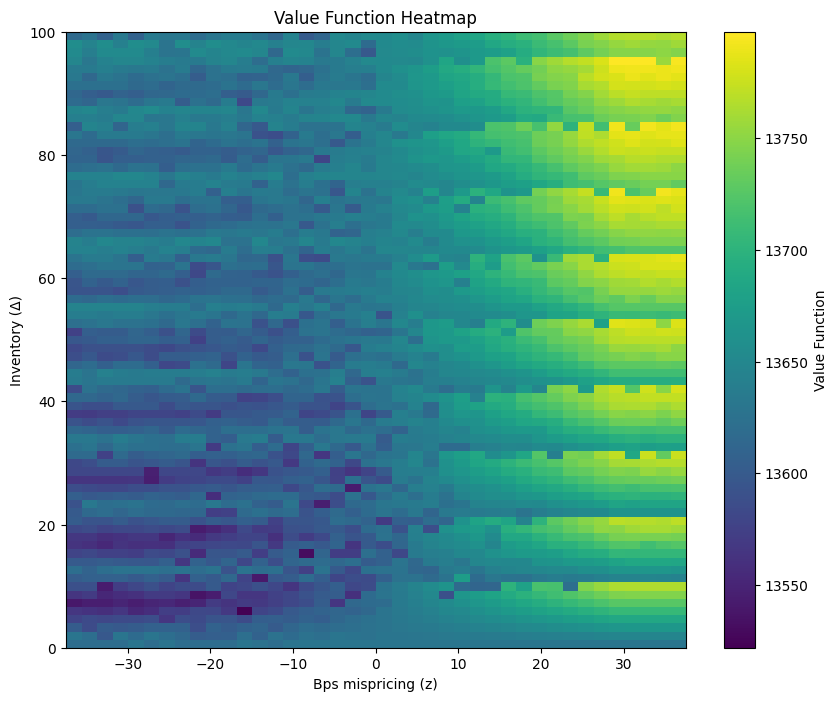

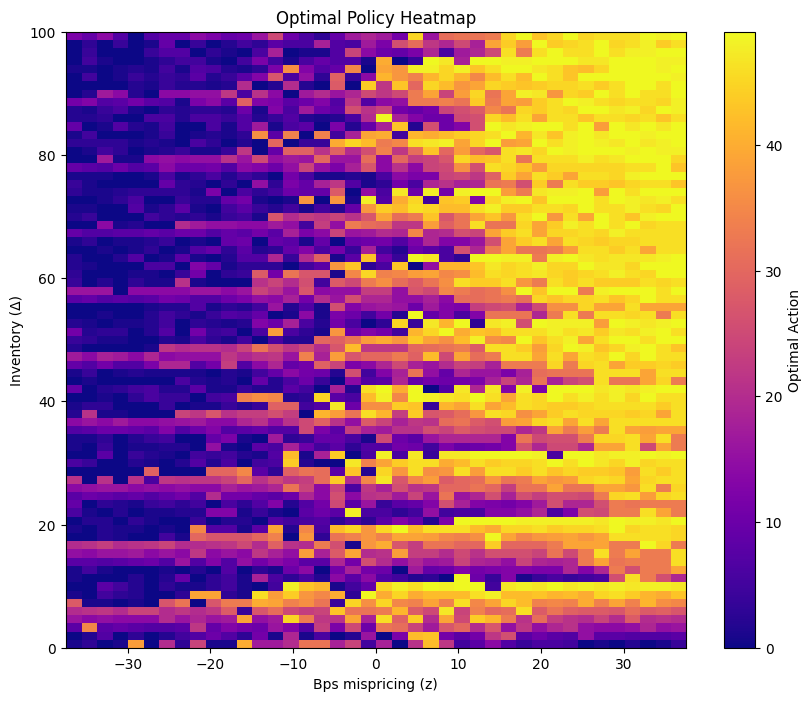

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mdptoolbox.mdp import ValueIteration

class AMM_MDP:
    def __init__(self, T, Delta_bar, R0, R1, gamma, sigma, mu, phi, g, INV_SPACE=75, Z_SPACE=40, SWAP_SPACE=50):
        """
        T: Total num blocks
        Delta_bar: Maximum inventory
        R0, R1: Initial reserves of the both assets in AMM
        gamma: AMM fee
        sigma: Volatility of log mispricing
        mu: Drift of log mispricing
        phi: Running inventory cost coefficient
        g: Gas cost per transaction
        """
        self.T = T
        self.Delta_bar = Delta_bar
        self.R0 = R0
        self.R1 = R1
        self.L = self.R0 * self.R1
        self.gamma = gamma
        self.sigma = sigma
        self.mu = mu
        self.phi = phi
        self.g = g
        self.INV_SPACE = INV_SPACE
        self.Z_SPACE = Z_SPACE
        self.SWAP_SPACE = SWAP_SPACE

        # discretize state and action spaces
        self.Delta_space = np.linspace(0, Delta_bar, self.INV_SPACE)  # inventory space
        self.z_space = np.linspace(-1.25 * gamma, 1.25 * gamma, self.Z_SPACE)  # mispricing space
        self.actions = np.linspace(0, Delta_bar / 10, self.SWAP_SPACE)  # swap sizes space

    def transition(self, Delta, z, a):
        """
        Compute the next state given the current state (Delta, z) and action (a).

        Delta: Current inventory
        z: Current log mispricing
        a: Action (amount to swap)
        Returns: (Delta_next, z_next, R0_next, R1_next, reward)
        """
        # update inventory
        a = min(a, Delta)

        Delta_next = max(Delta - a, 0)

        # update mispricing w initial arbitrageur jump
        z_star = np.clip(z, -self.gamma, self.gamma)


        # update reserves
        p_init = self.R1/self.R0
        if a > 0:
            R0_next = self.R0 + a
            R1_next = self.L / R0_next
        else:
            R0_next, R1_next = self.R0, self.R1 
        
        p_next = R1_next/R0_next
        
        # 10000 is for converting to bps
        z_next = z_star + 10000*(p_next-p_init)/p_init
        
        # 10000 is for converting to bps
        execution_price_improvement = (z_star + z_next)/(2*10000) * (p_init+p_next)/2 * a
        inventory_cost = -self.phi * abs(Delta)
        gas_cost = -self.g * (a > 0)
        
        reward = execution_price_improvement + inventory_cost + gas_cost
        
        z_next = z_next + self.mu + self.sigma * np.random.normal()
        
        return Delta_next, z_next, R0_next, R1_next, reward
    
    def state_index(self, Delta, z):
        """
        Map a continuous state (Delta, z) to a discrete index.
        """
        Delta_idx = np.searchsorted(self.Delta_space, Delta) - 1
        z_idx = np.searchsorted(self.z_space, z) - 1
        return Delta_idx * len(self.z_space) + z_idx

    def build_mdp_matrices(self):
        n_states = len(self.Delta_space) * len(self.z_space)
        n_actions = len(self.actions)
        
        P = np.zeros((n_actions, n_states, n_states))
        R = np.zeros((n_states, n_actions))

        for i, Delta in enumerate(self.Delta_space):
            for j, z in enumerate(self.z_space):
                state_idx = i * len(self.z_space) + j
                for k, a in enumerate(self.actions):
                    # Simulate transition
                    Delta_next, z_next, _, _, reward = self.transition(Delta, z, a)
                    reward = np.clip(reward, -1e5, 1e5)


                    # Find next state index
                    next_state_idx = self.state_index(Delta_next, z_next)

                    # Update matrices
                    P[k, state_idx, next_state_idx] += 1
                    R[state_idx, k] = reward

        # normalize probabilities
        for k in range(n_actions):
            row_sums = P[k].sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            P[k] /= row_sums

        return P, R

    def solve_mdp(self, discount_factor=0.99):
        """
        Solve the MDP using value iteration.

        discount_factor: Discount factor for future rewards
        Returns: Optimal policy
        """
        P, R = self.build_mdp_matrices()
        
        vi = ValueIteration(P, R, discount_factor)
        vi.run()
        self.value_function = vi.V
        self.policy = np.array(vi.policy)

        return self.policy
    
    def simulate(self, policy, num_simulations=100):
        """
        Simulate the MDP policy over multiple runs and calculate the mean inventory path.

        Args:
            policy (array): Optimal policy mapping states to actions.
            num_simulations (int): Number of independent simulations to run.

        Returns:
            np.array: Mean inventory path over all simulations.
        """
        inventory_paths = []

        for _ in range(num_simulations):
            Delta = self.Delta_bar
            z = 0 
            inventory = [Delta]

            for t in range(self.T):
                # current state index
                Delta_idx = np.searchsorted(self.Delta_space, Delta) - 1
                z_idx = np.searchsorted(self.z_space, z) - 1
                state_index = Delta_idx * len(self.z_space) + z_idx

                # get action from policy and constrain it
                action_index = policy[state_index]
                action = self.actions[action_index]
                action = min(action, Delta) 

                # transition
                Delta, z, _, _, _ = self.transition(Delta, z, action)
                inventory.append(Delta)

            inventory_paths.append(inventory)
        
        return np.mean(inventory_paths, axis=0)

    
# MDP params
T = 1000
Delta_bar = 100
R0 = 1e5
R1 = 1e5 * 5000
gamma = 30
g = 2
sigma = 20
mu = 0
phi = 0.0


mdp = AMM_MDP(T, Delta_bar, R0, R1, gamma, sigma, mu, phi, g)

#  transition + reward matrices
P, R = mdp.build_mdp_matrices()

# Solve w value iteration
vi = ValueIteration(P, R, .99, epsilon=1e-6)
vi.run()

# Reshape the results
value_function = np.array(vi.V).reshape((len(mdp.Delta_space), len(mdp.z_space)))
optimal_policy = np.array(vi.policy).reshape((len(mdp.Delta_space), len(mdp.z_space)))

# Plot Value Function
plt.figure(figsize=(10, 8))
plt.imshow(value_function, origin='lower', aspect='auto',
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap='viridis')
plt.colorbar(label='Value Function')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Value Function Heatmap')
plt.show()

# Plot Optimal Policy
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy, origin='lower', aspect='auto',
           extent=[min(mdp.z_space), max(mdp.z_space), min(mdp.Delta_space), max(mdp.Delta_space)],
           cmap='plasma')
plt.colorbar(label='Optimal Action')
plt.xlabel('Bps mispricing (z)')
plt.ylabel('Inventory (Δ)')
plt.title('Optimal Policy Heatmap')
plt.show()

In [12]:
# Solve the MDP to get the optimal policy
optimal_policy = mdp.solve_mdp(discount_factor=0.95)

# Simulate the policy with debug outputs
inventory_path, mispricing_path = mdp.simulate(optimal_policy)

ValueError: too many values to unpack (expected 2)

Running simulation for phi = 0
Running simulation for phi = 0.1
Running simulation for phi = 1
Running simulation for phi = 10
Total computation time: 128.40 seconds


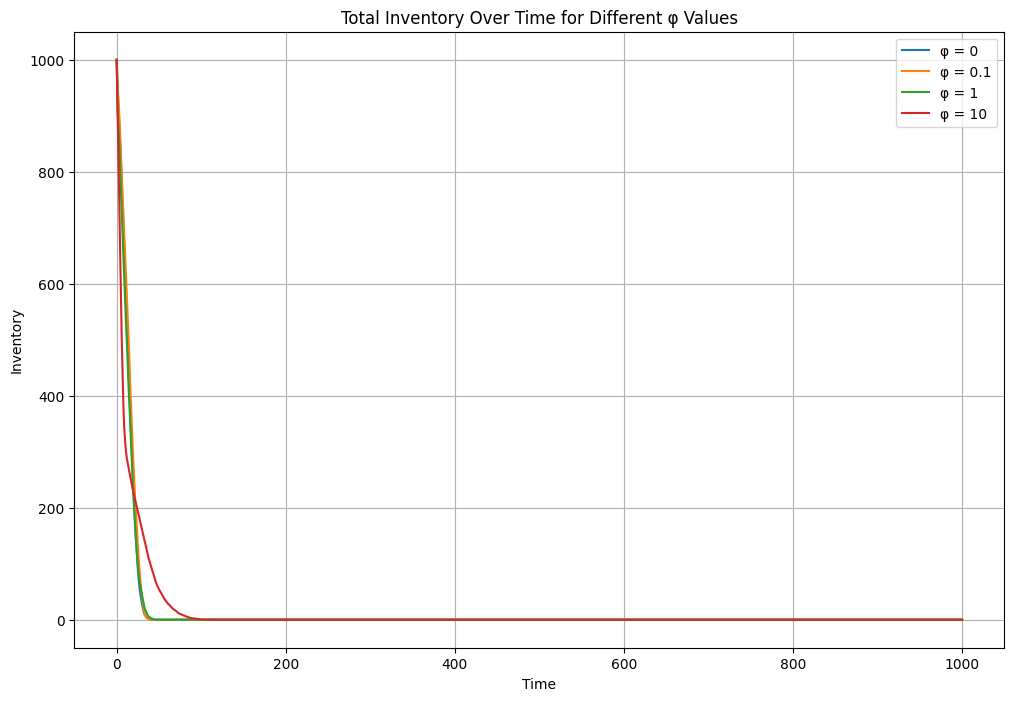

In [13]:
# Inventory as phi changes (WORK IN PROGRESS)

from mdptoolbox.mdp import ValueIteration
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox
import time
import pickle

def run_simulation(phi_value, mdp, T, discount_factor=0.99):
    mdp.phi = phi_value
    P, R = mdp.build_mdp_matrices()
    vi = ValueIteration(P, R, discount_factor)
    vi.run()
    policy = np.array(vi.policy)
    return mdp.simulate(policy)

phi_values = [0, .1, 1, 10]
T = 1000
Delta_bar = 1000
R0 = 1e5
R1 = 1e5 * 5000
gamma = 30
sigma = 10
g = 2
phi = 0
mu = 0
INV_SPACE = 50
Z_SPACE = 30
SWAP_SPACE = 25

mdp = AMM_MDP(T, Delta_bar, R0, R1, gamma, sigma, mu, phi, g, INV_SPACE, Z_SPACE, SWAP_SPACE)

# Run simulations and store results
results = {}
start_time = time.time()
for phi in phi_values:
    print(f"Running simulation for phi = {phi}")
    results[phi] = run_simulation(phi, mdp, T)
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")

# Store results
with open('amm_mdp_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Plot results
plt.figure(figsize=(12, 8))
for phi, inventory in results.items():
    plt.plot(inventory, label=f'φ = {phi}')

plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Total Inventory Over Time for Different φ Values')
plt.legend()
plt.grid(True)
plt.show()

# Function to load and plot results (can be used later without rerunning simulations)
def plot_stored_results(filename='amm_mdp_results.pkl'):
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    plt.figure(figsize=(12, 8))
    for phi, inventory in results.items():
        plt.plot(inventory, label=f'φ = {phi}')
    
    plt.xlabel('Time')
    plt.ylabel('Inventory')
    plt.title('Total Inventory Over Time for Different φ Values')
    plt.legend()
    plt.grid(True)
    plt.show()


Running simulation for sigma=1.000000...
Completed simulation for sigma=1.000000
Running simulation for sigma=1.467799...
Completed simulation for sigma=1.467799
Running simulation for sigma=2.154435...
Completed simulation for sigma=2.154435
Running simulation for sigma=3.162278...
Completed simulation for sigma=3.162278
Running simulation for sigma=4.641589...
Completed simulation for sigma=4.641589
Running simulation for sigma=6.812921...
Completed simulation for sigma=6.812921
Running simulation for sigma=10.000000...
Completed simulation for sigma=10.000000
Running simulation for sigma=14.677993...
Completed simulation for sigma=14.677993
Running simulation for sigma=21.544347...
Completed simulation for sigma=21.544347
Running simulation for sigma=31.622777...
Completed simulation for sigma=31.622777
Total computation time: 46.11 seconds


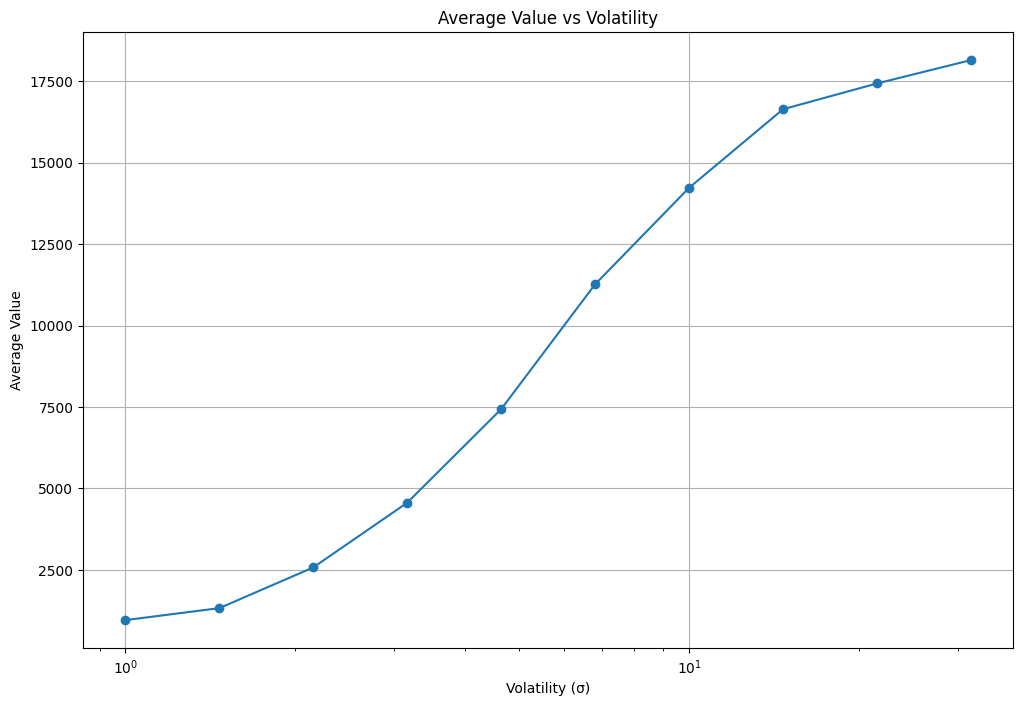

Volatility: 1.000000, Average Value: 958.688497
Volatility: 1.467799, Average Value: 1327.114453
Volatility: 2.154435, Average Value: 2576.867592
Volatility: 3.162278, Average Value: 4563.290492
Volatility: 4.641589, Average Value: 7435.129662
Volatility: 6.812921, Average Value: 11268.923144
Volatility: 10.000000, Average Value: 14229.611945
Volatility: 14.677993, Average Value: 16642.119896
Volatility: 21.544347, Average Value: 17434.007179
Volatility: 31.622777, Average Value: 18150.500101


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from mdptoolbox.mdp import ValueIteration


def run_volatility_simulation(sigma, mdp_params):
    """
    Run the MDP simulation for a given volatility (sigma).
    Args:
        sigma: Volatility value
        mdp_params: MDP parameter dictionary
    Returns:
        tuple: (sigma, mean value function)
    """
    mdp_params['sigma'] = sigma  # inject sigma into mdp params
    mdp = AMM_MDP(**mdp_params) 
    P, R = mdp.build_mdp_matrices()
    vi = ValueIteration(P, R, 0.95)
    vi.run()
    return sigma, np.mean(vi.V)


def sequential_volatility_analysis(volatilities, mdp_params):
    """
    Perform MDP simulations for a range of volatilities sequentially.
    Args:
        volatilities: List or array of volatilities to test
        mdp_params: Dictionary of MDP parameters
    Returns:
        List of tuples: [(sigma1, avg_value1), (sigma2, avg_value2), ...]
    """
    results = []
    for sigma in volatilities:
        print(f"Running simulation for sigma={sigma:.6f}...")
        result = run_volatility_simulation(sigma, mdp_params)
        results.append(result)
        print(f"Completed simulation for sigma={sigma:.6f}")
    return results


if __name__ == "__main__":
    # Parameters
    T = 1000
    Delta_bar = 1000
    R0 = 1e5
    R1 = 1e5 * 5000
    gamma = 30
    g = 2
    mu = 0
    phi = 0.0
    INV_SPACE = 50
    Z_SPACE = 25
    SWAP_SPACE = 25

    mdp_params = {
        'T': T, 'Delta_bar': Delta_bar, 'R0': R0, 'R1': R1, 'gamma': gamma, 'g': g,
        'mu': mu, 'phi': phi, 'INV_SPACE': INV_SPACE, 'Z_SPACE': Z_SPACE, 'SWAP_SPACE': SWAP_SPACE
    }

    volatilities = np.logspace(0, 1.5, 10)  # Logarithmically spaced volatilities (10^0 to 10^1.5), remember we're in bps space

    start_time = time.time()
    results = sequential_volatility_analysis(volatilities, mdp_params)
    end_time = time.time()

    print(f"Total computation time: {end_time - start_time:.2f} seconds")

    sigmas, avg_values = zip(*results)

    plt.figure(figsize=(12, 8))
    plt.plot(sigmas, avg_values, marker='o')
    plt.xscale('log')
    plt.xlabel('Volatility (σ)')
    plt.ylabel('Average Value')
    plt.title('Average Value vs Volatility')
    plt.grid(True)
    plt.show()

    for sigma, avg_value in results:
        print(f"Volatility: {sigma:.6f}, Average Value: {avg_value:.6f}")
